<a href="https://colab.research.google.com/github/Jason1Borne/ML_practice/blob/master/Muscle_Sensor_ensemble__inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://god.yanxishe.com/14

肌肉活动电信号推测手势

大赛简介

数据集采集：手臂皮肤放置8个传感器，每个传感器会得到8个肌肉电信号数据，一个手势共64个数据。训练集第65个数据为手势类别。

数据集共包含4种手势，选手需训练模型正确识别不同肌肉信号数据对应的手势。

0=摇滚，1=剪刀，2=布，3=OK

My score:  4th  98.3443% Accuracy

Using TensorFlow backend.


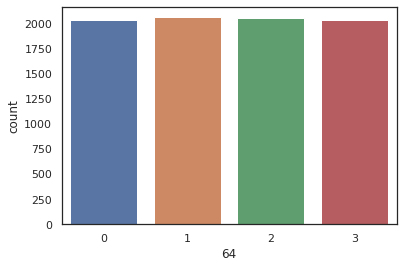

In [0]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Multiply, MaxPool1D, RepeatVector, Reshape, Activation, GlobalAveragePooling2D, MaxPool2D, Concatenate, Add, Flatten, Conv2D, Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')#画图设置

# 定义常量
num_classes = 4
batch_size = 512
max_epochs = 20
weigth_decay = 0

files = ['0.csv', '1.csv', '2.csv', '3.csv']

dataframe = []
for index, file in enumerate(files):
    df = pd.read_csv(file)
    dataframe.append(df)

train = pd.concat(dataframe)

train = train.drop('Unnamed: 0', axis=1)

Y = train["64"]
X = train.drop(labels = ["64"],axis = 1)
# free some space
del train

g = sns.countplot(Y)#画图，统计数量
Y.value_counts()#计算每个值的数量

X = np.transpose(X.values.reshape(-1, 8, 8, 1)/128, [0, 2, 1, 3])
Y = Y.values

from keras.utils.np_utils import to_categorical
Y = to_categorical(Y, 4)

In [0]:
from scipy.stats import pearsonr

# 计算通道之间两两的相关性
def pearsonr_cal(data):
    
    p = []
    
    # 每一组数据计算一次
    for d in data:
        temp = []
        for i in range(0, len(d)):
            for j in range(i + 1, len(d)):
                temp.append(pearsonr(d[i], d[j])[0])
        p.append(np.array(temp))
    
    return np.array(p)

train_x_pearson = pearsonr_cal(X.reshape(-1, 8, 8))

查看其中一个样本的输入特征


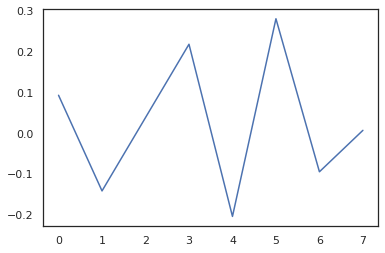

In [0]:
plt.figure()

plt.plot(X[1,0,:]) 

plt.show()

准备测试集数据

In [0]:
test = pd.read_csv('test.csv', header=None)
results = np.zeros((len(test), num_classes), dtype='float')
X_test = np.transpose(test.values.reshape(-1, 8, 8, 1)/128,[0, 2, 1, 3])

建立模型

In [0]:
def inception_block(inputs, filters):
    
    # 分支1
    conv_1 = Conv2D(filters=filters, kernel_size=[1, 1], strides=[1, 1], padding="same", activation="relu")(inputs)
    

    # 分支2
    conv_2 = Conv2D(filters=filters, kernel_size=[3, 3], strides=[1, 1], padding="same", activation="relu")(inputs)

    # 分支3
    conv_3 = Conv2D(filters=filters, kernel_size=[3, 3], strides=[1, 1], padding="same", activation="relu")(inputs)
    conv_3 = Conv2D(filters=filters, kernel_size=[3, 3], strides=[1, 1], padding="same", activation="relu")(conv_3)

    # 合并
    outputs = Concatenate(axis=3)([conv_1, conv_2, conv_3])
    outputs = Conv2D(filters=filters, kernel_size=[1, 1], strides=[1, 1], padding="same", activation="relu")(outputs)

    return outputs

def se_block(inputs, k): #SE Block模块
   
    # 输入尺寸
    input_shape = K.int_shape(inputs)

    # 全局平均池化
    outputs = GlobalAveragePooling2D()(inputs)

    # 计算每个通道的重要性
    outputs = Dense(units=int(input_shape[-1] / k), activation="relu")(outputs)
    outputs = Dense(units=input_shape[-1], activation="sigmoid")(outputs)
    
    # 重新标定每个通道
    outputs = RepeatVector(input_shape[1] * input_shape[2])(outputs)
    outputs = Reshape([input_shape[1], input_shape[2], input_shape[3]])(outputs)
    outputs = Multiply()([inputs, outputs])
    
    return outputs

def ims_layer(inputs, filters, pool_size):#特征提取层
    
    inception = inception_block(inputs, filters)
    pool = MaxPool2D(pool_size=pool_size, strides=pool_size, padding="same")(inception)
    se = se_block(pool, 4)
    
    return se 

def fc_layer(inputs, units):#最后的全连接层
    
    outputs = Dense(units=units, activation="relu")(inputs)
    outputs = Dropout(0.5)(outputs)
    
    return outputs

def model_build():
    # 原始输入数据
    raw_input = Input((8, 8, 1))
    # 相关系数输入
    pearson_input = Input((28, ))
    
    # 对原始信号提取特征
    # ims_1
    ims_1 = ims_layer(raw_input, 64, [1, 2]) 
    
    # ims_2
    ims_2 = ims_layer(ims_1, 128, [1, 4]) 
    
    # Flatten
    flatten = Flatten()(ims_2)
    
    # 连接原始信号特征和相关系数
    # concat
    concat = Concatenate()([flatten, pearson_input])
    
    # fc
    # fc_1
    fc_1 = fc_layer(concat, 512)
    # fc_2
    fc_2 = fc_layer(fc_1, 128)
                        
    # x_output
    x_output = Dense(units=4, activation="softmax")(fc_2)
    
    # 建立模型
    model = Model(inputs=[raw_input, pearson_input], outputs=x_output)
    # 编译模型
    model.compile(Adam(3e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping

def schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.8
    return lr


def callback_build(weights_file):   
    model_ckpt = ModelCheckpoint(weights_file, monitor="val_categorical_accuracy", save_best_only=True,
                                 save_weights_only=True, verbose=1)
    #early_stop = EarlyStopping(monitor='val_categorical_accuracy')
    lr_scheduler = LearningRateScheduler(schedule, verbose=10)
    lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=3, verbose=1,
                                     factor=0.9, min_lr=1e-8)
    early_stop = EarlyStopping(monitor="val_categorical_accuracy", min_delta=0, patience=500, mode="auto", restore_best_weights=True)
    callback_list = [model_ckpt, lr_scheduler, lr_reduction]
    return callback_list

In [0]:
X.shape

(8175, 8, 8, 1)

In [0]:
Y.shape

(8175, 4)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical



models = []
histories = []
scores = []
seed = 996
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train, valid in kfold.split(X, np.zeros((X.shape[0],1))):
    
    

    
    X_train = [X[train], train_x_pearson[train]]
    X_valid = [X[valid], train_x_pearson[valid]]
    

    Y_train = Y[train]
    
    Y_valid = Y[valid]

    weights_file = ("best_wegihts_model-%d")%len(models) + ".h5"
    callbacks = callback_build(weights_file)
    model = model_build()
    history = model.fit(X_train, Y_train,
                        batch_size=64,
                        epochs = 100,
                        callbacks = callbacks,
                        validation_data = [X_valid, Y_valid]
                        )
    # reload best weights of model
    model.load_weights(weights_file, by_name=True)
    print("Model loaded.")
    # evaluate
    score = model.evaluate(X_valid, Y_valid)
    scores.append(score)
    models.append(model)
    histories.append(history)
print("scores", scores)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6540 samples, validate on 1635 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
Epoch 1/100
6080/6540 [==========================>...] - ETA: 0s - loss: 0.7914 - categorical_accuracy: 0.6781
Epoch 00001: val_categorical_accuracy improved from -inf to 0.93272, saving model to best_wegihts_model-0.h5
6540/6540 [==============================] - 3s 439us/sample - loss: 0.7517 - categorical_accuracy: 0.6963 - val_loss: 0.1961 - val_categorical_accuracy: 0.9327

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
Epoch 2/100
6144/6540 [===========================>..] - ETA: 0s - loss: 0.1875 - categorical_accuracy: 0.9383
Epoch 00002: val_categorical_accuracy improved from 0.93272 to 0.96820, saving model to best_wegihts_model-0.h5
6540/6540 [==============================] - 1s 125us/sample - loss: 0.1882 - categorical_accurac

In [0]:
Y_test = model.predict(X_test)

In [0]:
result = Y_test.argmax(axis=-1)

In [0]:
model = models[0]
Y_test = model.predict(X_test)
for i in range(1,5):
    model = models[i]
    Y_test += model.predict(X_test)
Y_test /= 5
label = np.argmax(Y_test, axis=1)
index = np.arange(0, len(label)) + 1
summit = np.hstack([index[:, np.newaxis], label[:, np.newaxis]])
pd.DataFrame(summit).to_csv('key.csv', header=False, index=False)

In [0]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(len(models)):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['loss']))
    plt.plot(epoch_range,history.history['loss'],'g-',label='Training loss')
    plt.plot(epoch_range,history.history['val_loss'],'r--',label='Validation loss')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.xlim([0,epochs])
    plt.ylim([0, 1])


plt.subplot(2,1,2)
for i in range(len(models)):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['acc']))
    plt.plot(epoch_range,history.history['acc'],'g-',label='Training accuracy')
    plt.plot(epoch_range,history.history['val_acc'],'r--',label='Validation accuracy')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.xlim([0,epochs])
    plt.ylim([0.8, 1])
plt.show()

In [0]:
label = np.argmax(results, axis=1)
index = np.arange(0, len(label)) + 1
summit = np.hstack([index[:, np.newaxis], label[:, np.newaxis]])
pd.DataFrame(summit).to_csv('key.csv', header=False, index=False)

其他尝试过的模型, ohter models

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, GlobalAveragePooling2D, Concatenate, Activation, Add, Flatten, Conv2D, Input, Dense, Dropout, Activation, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')



def model_build():
    input = Input(shape = [8, 8, 1])

    x = Concatenate(axis=1)([input, input[:, :2, :, :]])
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = "valid", activation = "relu")(x)
    x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)

    x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = "valid", activation = "relu")(x)
    x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)

    # x = Concatenate(axis=1)([x, x[:, 0, :, :]])
    # x = Conv2D(filters = 128, kernel_size = (2,2), padding = "valid", activation = "relu")(x)
    # x = BatchNormalization()(x)

    x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "valid", activation = "relu")(x)
    x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)

    x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 256, kernel_size = (3,3), padding = "valid", activation = "relu")(x)
    x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(filters = 512, kernel_size = (1,1), padding = "valid", activation = "relu")(x)
    x = BatchNormalization()(x)
    
    #x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    #x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)

    #x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    #x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    # x = Conv2D(filters = 1024, kernel_size = (3,3), padding = "valid", activation = "relu")(x)
    # x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    # x = BatchNormalization()(x)
    x = Conv2D(filters = 512, kernel_size = (1,1), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    
    
    #x = Concatenate(axis=1)([x, x[:, :2, :, :]])
    x = Conv2D(filters = 1024, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    #x = ZeroPadding2D(padding=(0,1), data_format='channels_last')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters = 1024, kernel_size = (1,1), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    x = Dense(512, activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(4, activation = "softmax")(x)
    model = Model(input, output)
    adam = Adam(lr = 3e-4)

    model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

# model = model_build()
# model.summary()

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, Activation, Add, Flatten, Conv2D, Input, Dense, Dropout, Activation, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

#Inception V4

def Inception_block(input, output_channels):
    x1 = Conv2D(filters = output_channels, kernel_size = (1,1), padding = "same", activation = "relu")(input)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(filters = output_channels, kernel_size = (1,3), padding = "same", activation = "relu")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(filters = output_channels, kernel_size = (3,1), padding = "same", activation = "relu")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(filters = output_channels, kernel_size = (1,3), padding = "same", activation = "relu")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(filters = output_channels, kernel_size = (3,1), padding = "same", activation = "relu")(x1)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(filters = output_channels, kernel_size = (1,1), padding = "same", activation = "relu")(input)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(filters = output_channels, kernel_size = (1,3), padding = "same", activation = "relu")(x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(filters = output_channels, kernel_size = (3,1), padding = "same", activation = "relu")(x2)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(filters = output_channels, kernel_size = (1,1), padding = "same", activation = "relu")(input)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(filters = output_channels, kernel_size = (1,1), padding = "same", activation = "relu")(input)    
    x4 = Conv2D(filters = output_channels, kernel_size = (2,2), padding = "same", activation = "relu")(x4)    


    x = Concatenate()([x1, x2, x3, x4])
    x = Conv2D(filters = output_channels, kernel_size = (1,1), padding = "same", activation = "relu")(x)    
    x = Dropout(0.4)(x)
    return x

def model_build():
    input = Input(shape = [8, 8, 1])
    pearson_input = Input(shape=[28])
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(input)
    x = Inception_block(x, 64)
    x = Inception_block(x, 128)
    x = Inception_block(x, 256)

    x = Flatten()(x)

    concat = Concatenate()([x, pearson_input])

    x = Dense(512, activation = "relu")(concat)
    x = Dropout(0.4)(x)
    x = Dense(256, activation = "relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(4, activation = "softmax")(x)
    model = Model([input, pearson_input], output)
    adam = Adam(lr = 3e-4)

    model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

# model = model_build()
# model.summary()

In [0]:



def model_build():
    input = Input(shape = [8, 8, 1])
    
    res_x_11 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(input)
    x = BatchNormalization()(res_x_11)
    x = Conv2D(filters = 128, kernel_size = (1,1), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    res_x_12 = Conv2D(filters = 512, kernel_size = (1,1), padding = "same")(x)
    res_x_12 = BatchNormalization()(res_x_12)
    x = Add()([res_x_11, res_x_12])
    x = Activation('relu')(x)
    res_x_21 = Dropout(0.5)(x)

    x = Conv2D(filters = 128, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_21)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    res_x_22 = Conv2D(filters = 512, kernel_size = (1,1), padding = "same")(x)
    res_x_22 = BatchNormalization()(res_x_22)
    x = Add()([res_x_21, res_x_22])
    x = Activation('relu')(x)
    res_x_31 = Dropout(0.5)(x)

    x = Conv2D(filters = 128, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_31)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    res_x_32 = Conv2D(filters = 512, kernel_size = (1,1), padding = "same")(x)
    res_x_32 = BatchNormalization()(res_x_32)
    x = Add()([res_x_31, res_x_32])
    x = Activation('relu')(x)
    res_x_41 = Dropout(0.5)(x)

    x = Conv2D(filters = 128, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_41)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    res_x_42 = Conv2D(filters = 512, kernel_size = (1,1), padding = "same")(x)
    res_x_42 = BatchNormalization()(res_x_42)
    x = Add()([res_x_41, res_x_42])
    x = Activation('relu')(x)
    res_x_51 = Dropout(0.5)(x)  

    x = Conv2D(filters = 128, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_51)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    res_x_52 = Conv2D(filters = 512, kernel_size = (1,1), padding = "same")(x)
    res_x_52 = BatchNormalization()(res_x_52)
    x = Add()([res_x_51, res_x_52])
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    #res_x_61 = Dropout(0.5)(x)

    # x = Conv2D(filters = 64, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_61)
    # x = BatchNormalization()(x)
    # x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    # x = BatchNormalization()(x)
    # res_x_62 = Conv2D(filters = 256, kernel_size = (1,1), padding = "same")(x)
    # res_x_62 = BatchNormalization()(res_x_62)
    # x = Add()([res_x_61, res_x_62])
    # x = Activation('relu')(x)
    # res_x_71 = Dropout(0.5)(x)

    # x = Conv2D(filters = 64, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_71)
    # x = BatchNormalization()(x)
    # x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    # x = BatchNormalization()(x)
    # res_x_72 = Conv2D(filters = 256, kernel_size = (1,1), padding = "same")(x)
    # res_x_72 = BatchNormalization()(res_x_72)
    # x = Add()([res_x_31, res_x_32])
    # x = Activation('relu')(x)
    # res_x_81 = Dropout(0.5)(x)

    # x = Conv2D(filters = 64, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_81)
    # x = BatchNormalization()(x)
    # x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    # x = BatchNormalization()(x)
    # res_x_82 = Conv2D(filters = 256, kernel_size = (1,1), padding = "same")(x)
    # res_x_82 = BatchNormalization()(res_x_82)
    # x = Add()([res_x_81, res_x_82])
    # x = Activation('relu')(x)
    # res_x_91 = Dropout(0.5)(x)

    # x = Conv2D(filters = 64, kernel_size = (1,1), padding = "same", activation = "relu")(res_x_91)
    # x = BatchNormalization()(x)
    # x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(x)
    # x = BatchNormalization()(x)
    # res_x_92 = Conv2D(filters = 256, kernel_size = (1,1), padding = "same")(x)
    # res_x_92 = BatchNormalization()(res_x_92)
    # x = Add()([res_x_91, res_x_92])
    # x = Activation('relu')(x)
    # x = Dropout(0.5)(x)

    x = Flatten()(x)
    
    x = Dense(512, activation = "relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation = "relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation = "softmax")(x)
    model = Model(input, output)
    adam = Adam(lr = 3e-4)

    model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

# model = model_build()
# model.summary()